In [4]:
# ! conda install -c conda-forge ipywidgets

In [1]:
import matplotlib.pyplot as plt
import math
import tensorflow
print(tensorflow.__version__)

2.4.0


In [2]:
from transformers import AutoModelForCausalLM, AutoTokenizer
import torch


tokenizer = AutoTokenizer.from_pretrained("microsoft/DialoGPT-medium")


In [3]:
model = AutoModelForCausalLM.from_pretrained("microsoft/DialoGPT-medium")

In [4]:
user = AutoModelForCausalLM.from_pretrained("microsoft/DialoGPT-medium")

In [5]:
user.to('cpu')
user.eval()
# Let's chat for 5 lines
sentences = ["Did you see \"Titanic\"?",
            "I saw it twelve times.",
            "I have the DVD.",
            "Let's go to your home.",
            "And then we can go to my home.",
            "I always cry at the end."]
for step in range(len(sentences)):
    # encode the new user input, add the eos_token and return a tensor in Pytorch
#     new_user_input_ids = tokenizer.encode(input(">> User:") + tokenizer.eos_token, return_tensors='pt')
    new_user_input_ids = tokenizer.encode(sentences[step] + tokenizer.eos_token, return_tensors='pt')
    print("User:", sentences[step])
    
    # append the new user input tokens to the chat history
    bot_input_ids = torch.cat([chat_history_ids, new_user_input_ids], dim=-1) if step > 0 else new_user_input_ids

    # generated a response while limiting the total chat history to 1000 tokens, 
    chat_history_ids = user.generate(bot_input_ids, 
                                     max_length=1000, 
                                     pad_token_id=tokenizer.eos_token_id, 
                                     no_repeat_ngram_size=5,
#                                      repetition_penalty=1.1
                                     
                                     )

    # pretty print last ouput tokens from bot
    print("DialoGPT: {}".format(tokenizer.decode(chat_history_ids[:, bot_input_ids.shape[-1]:][0], skip_special_tokens=True)))

User: Did you see "Titanic"?
DialoGPT: I did, but I don't think I can remember it.
User: I saw it twelve times.
DialoGPT: I saw it once.
User: I have the DVD.
DialoGPT: I have the CD.
User: Let's go to your home.
DialoGPT: I have a DVD.
User: And then we can go to my home.
DialoGPT: I'm going to go to your home.
User: I always cry at the end.
DialoGPT: I cry at the end.


# RL test

In [6]:
import math, random
import numpy as np

import torch
import torch.nn as nn
import torch.optim as optim
import torch.autograd as autograd 
import torch.nn.functional as F

In [7]:
def jaccard_similarity(list1, list2):
    intersection = len(list(set(list1).intersection(list2)))
    union = (len(list1) + len(list2)) - intersection
    return float(intersection) / union

In [8]:
# Use CUDA
USE_CUDA = torch.cuda.is_available()
Variable = lambda *args, **kwargs: autograd.Variable(*args, **kwargs).cuda() if USE_CUDA else autograd.Variable(*args, **kwargs)

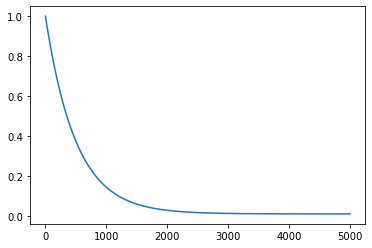

In [9]:
epsilon_start = 1.0
epsilon_final = 0.01
epsilon_decay = 500

epsilon_by_frame = lambda frame_idx: epsilon_final + (epsilon_start - epsilon_final) * math.exp(-1. * frame_idx / epsilon_decay)
# epsilon_by_frame = lambda frame_idx: max(epsilon_final, epsilon_start*(0.995**frame_idx))
plt.plot([epsilon_by_frame(i) for i in range(5000)])
plt.show()

## Replay Buffer

In [10]:
from collections import deque

class ReplayBuffer(object):
    def __init__(self, capacity):
        self.buffer = deque(maxlen=capacity)
    
    def push(self, state, action, reward, next_state, done):
        state      = np.expand_dims(state, 0)
        next_state = np.expand_dims(next_state, 0)
            
        self.buffer.append((state, action, reward, next_state, done))
    
    def sample(self, batch_size):
        state, action, reward, next_state, done = zip(*random.sample(self.buffer, batch_size))
        return np.concatenate(state), action, reward, np.concatenate(next_state), done
    
    def __len__(self):
        return len(self.buffer)

In [11]:
# def compute_td_loss(batch_size):
#     state, action, reward, next_state, done = replay_buffer.sample(batch_size)

#     state      = Variable(torch.FloatTensor(np.float32(state)))
#     next_state = Variable(torch.FloatTensor(np.float32(next_state)), requires_grad=False)
#     action     = Variable(torch.LongTensor(action))
#     reward     = Variable(torch.FloatTensor(reward))
#     done       = Variable(torch.FloatTensor(done))

# #     q_values      = model(state)
# #     next_q_values = model(next_state)

# #     q_value          = q_values.gather(1, action.unsqueeze(1)).squeeze(1)
# #     next_q_value     = next_q_values.max(1)[0]
# #     expected_q_value = reward + gamma * next_q_value * (1 - done)
    
#     loss = (q_value - Variable(expected_q_value.data)).pow(2).mean()
        
#     optimizer.zero_grad()
#     loss.backward()
# #     for param in model.parameters():
# #             param.grad.data.clamp_(-1, 1)
#     optimizer.step()
    
#     return loss

In [12]:
def act(model, state, epsilon):
    if random.random() > epsilon:
        state   = Variable(torch.FloatTensor(state).unsqueeze(0), requires_grad=False)
        q_value = model.forward(state)
        action  = q_value.max(1)[1].item()
    else:
        action = env.action_space.sample()
        #action = random.randrange(env.action_space.n)
    return action

In [13]:
def next_step(action):
    question = user.generate(action, max_length=1000, 
                             pad_token_id=tokenizer.eos_token_id, 
                             num_beams=3,
                             num_return_sequences=2,
                             early_stopping=True,
                             no_repeat_ngram_size=2
                            ) if frame > 0 else chat_history_ids
    
    reward -= jaccard_similarity(answer.numpy(), context.numpy())
    return new_state, reward, False

In [14]:
def decode(token_ids):
    return tokenizer.decode(token_ids, skip_special_tokens=True)

In [15]:
def discount_rewards(r, gamma=0.99):
    """ take 1D float array of rewards and compute discounted reward """
    size = len(r)
    discounted_r = torch.zeros(size)
    running_add = 0
    for t in reversed(range(0, size)):
        running_add = running_add * gamma + r[t]
        discounted_r[t] = running_add
    return discounted_r

In [16]:
# x = answers[-1]
# # torch.tensor(x.size())
# y = model(x)[0]
# w = y.sum(dim=1)
# q = w/w
# q.sum()

In [17]:
# model.base_model.forward(answers[-2], output_hidden_states=True)['last_hidden_state'].max(dim=0)[0]

In [18]:
def compute_reward(questions, answers):
    model.train()
    t1 = questions[-1].to(device)
    t2 = answers[-1].to(device)
#     print(t1)
    A = model(t1)[0]
#     print(t2, len(t2))
    B = model(t2)[0]
    lenA = list(A.size())[0]
    lenB = list(B.size())[0]
#     print(lenA, lenB)
#     lenA = len(A.detach().numpy())
#     lenB = len(B.detach().numpy())
    max_len = np.max([lenA, lenB])
#     extra = torch.zeros(size=(max_len-len(A.detach().numpy()),tokenizer.vocab_size))
#     extra[:,-1] = 1
    
    if lenA > lenB:
        extra = torch.zeros(size=(max_len-lenB,tokenizer.vocab_size)).to(device)
        extra[:,-1] = 1
        A , B = torch.softmax(A, dim=-1), torch.cat([torch.softmax(B, dim=-1), extra]), 
    
    else:
        extra = torch.zeros(size=(max_len-lenA,tokenizer.vocab_size)).to(device)
        extra[:,-1] = 1
        A , B = torch.cat([torch.softmax(A, dim=-1), extra]), torch.softmax(B, dim=-1)
        
    # loss = F.cosine_similarity(A,B, dim=-2)
#     loss = -torch.mm(A, B.transpose(1, 0)).sum()

    # loss = -F.cosine_similarity(torch.softmax(A, dim=-1),torch.softmax(B, dim=-1))
    
    def log_prob(tokens, debug=False):
        # p = log(P(b|a)) / N
        output_logits = model(tokens.to(device))[0]
        p = 1
        if debug: print('logits', output_logits, 'tokens', tokens)
        for t, logit in zip(tokens, output_logits):
            p *= torch.softmax(logit, dim=-1)[t]
        if debug: print('p', p)
        p_log = torch.log(p) / len(tokens) # (tokens/tokens).sum()# / len(tokens) # lenB # len(tokens_b)
        if p == 0:
            print('infinite')
            return torch.log(p+10e-10)
        else:
            return p_log

    def log_prob_r1(tokens, debug=False):
        # p = log(P(b|a)) / N
        output_logits = model(tokens.to(device))[0]
        p = 0
        if debug: print('logits', output_logits, 'tokens', tokens)
        for t, logit in zip(tokens, output_logits):
            p += torch.softmax(logit, dim=-1)[t]
        if debug: print('p', p)
        p_log = p / len(tokens) # (tokens/tokens).sum()# / len(tokens) # lenB # len(tokens_b)
        if p == 0:
            print('infinite')
            return torch.log(p+10e-10)
        else:
            return p_log
    # reward 1
    x = [log_prob_r1(d) for d in dummy_responses[:30]]
    r1 = torch.stack(x)
    r1 = -torch.mean(r1) # if r1 else 0
    
    # reward 2
#     model.transformer.wte.weight[text_index,:]
#     if len(answers)<2:
#         emb1 = model.get_input_embeddings()(t1).max(dim=0)[0]
#     else:
#         emb1 = model.get_input_embeddings()(answers[-2]).max(dim=0)[0]
#     emb2 = model.get_input_embeddings()(t2).max(dim=0)[0]
#     r2 = -torch.log(F.cosine_similarity(emb1,emb2,dim=-1))

#     emb1 = model.get_input_embeddings()(t1).max(dim=0)[0]
#     emb2 = model.get_input_embeddings()(t2).max(dim=0)[0]
#     r2_2 = -torch.log(F.cosine_similarity(emb1,emb2,dim=-1))
    
    
    if len(answers)<2:
        emb1 = model.base_model.forward(t1, output_hidden_states=True)['last_hidden_state'].max(dim=0)[0]
    else:
        emb1 = model.base_model.forward(answers[-2], output_hidden_states=True)['last_hidden_state'].max(dim=0)[0]
    emb2 = model.base_model.forward(t2, output_hidden_states=True)['last_hidden_state'].max(dim=0)[0]
#     r2 = -torch.log(torch.clamp(F.cosine_similarity(emb1,emb2,dim=-1), min=1e-9))
    r2 = -F.cosine_similarity(emb1,emb2,dim=-1)

    emb1 = model.base_model.forward(t1, output_hidden_states=True)['last_hidden_state'].max(dim=0)[0]
    emb2 = model.base_model.forward(t2, output_hidden_states=True)['last_hidden_state'].max(dim=0)[0]
#     r2_2 = -torch.log(torch.clamp(F.cosine_similarity(emb1,emb2,dim=-1), min=1e-9))
    r2_2 = -F.cosine_similarity(emb1,emb2,dim=-1)
    
    
    
    
    
    # reward 3
    r3 = log_prob_r1(t2, debug=False)
#     print(t2, t2.size())
    
#     y = model(t2)[0]
#     w = y.sum(dim=1)
#     q = w/w
#     r4 = q.sum()
    print('r1:', r1, 'r2:', r2, 'r2_2:', r2_2, 'r3:', r3)
    
    R = 0.25*r1 + 0.25*r2 + 0.25*r2_2 #+ 0.5*r3 #* 0.01*r4
#     R = 1*r2 + 1*r2_2 #+ 0.5*r3 #* 0.01*r4

#     print(R)
    return -R


In [19]:
# for p in model.base_model.parameters():
#     print(p.shape)

In [20]:
dummy_responses = [torch.tensor([tokenizer.eos_token_id]),
                   tokenizer.encode("1" + tokenizer.eos_token, return_tensors='pt')[0],
                   tokenizer.encode("I" + tokenizer.eos_token, return_tensors='pt')[0],
                   tokenizer.encode("I'm" + tokenizer.eos_token, return_tensors='pt')[0],
                   tokenizer.encode("I", return_tensors='pt')[0],
                   tokenizer.encode(".." + tokenizer.eos_token, return_tensors='pt')[0],
                   tokenizer.encode("!" + tokenizer.eos_token, return_tensors='pt')[0],
                   tokenizer.encode(":D" + tokenizer.eos_token, return_tensors='pt')[0],
                   tokenizer.encode("I don't know what you're talking about"+ tokenizer.eos_token, return_tensors='pt')[0],
                   tokenizer.encode("I don't know"+ tokenizer.eos_token, return_tensors='pt')[0],
                   tokenizer.encode("I don't know, I don't know"+ tokenizer.eos_token, return_tensors='pt')[0],
                   tokenizer.encode("You don't know"+ tokenizer.eos_token, return_tensors='pt')[0],
                  ]
# for i in range(256):
#     s = tokenizer.encode(tokenizer.decode([i]) + tokenizer.eos_token, return_tensors='pt')[0]
#     dummy_responses.append(s)
# dummy_responses

In [21]:
# for i in range(290-34):
#     print(tokenizer.decode([i]))

In [22]:
# model(chat_history_ids)[0].max(dim=1)[0][0,:].shape

In [23]:
# model(chat_history_ids)[0].max(dim=1)

In [24]:
def is_dummy_sentence(sent):
    for d in dummy_responses:
        if sent.size()[0] == d.to(device).size()[0] and all(sent == d.to(device)):
            return True
    return False

In [25]:
for param in model.base_model.parameters():
    param.requires_grad = False

for param in list(model.base_model.parameters())[-5:]:
    param.requires_grad = True

In [26]:
# model.base_model

# Training Loop

In [27]:
# torch.save(model.state_dict(), 'models/test')

In [28]:
USE_CUDA = True
if USE_CUDA:
    device ='cuda'
    model  = model.cuda()
    user   = user.cuda()
else:
    device = 'cpu'
    model  = model.cpu()
#     user = user.cpu()

In [33]:
chat_history_ids = tokenizer.encode(tokenizer.bos_token + "Hello" + tokenizer.eos_token, return_tensors='pt')

reward = 0

optimizer = optim.Adam(model.parameters(), lr=0.00025)
# replay_buffer = ReplayBuffer(10000)
batch_size = 64
gamma      = 0.99  # 0.99
# ep_rewards = []

for episode in range(200):
    chat_history_ids = tokenizer.encode("Hello" + tokenizer.eos_token, return_tensors='pt').to(device)
    questions = []
    answers   = []
    turns     = []
    rewards   = []
    model.eval()
    max_length = 1000
    for frame in range(20):
        epsilon = epsilon_by_frame(frame)
        # encode the new user input, add the eos_token and return a tensor in Pytorch
    #     new_user_input_ids = tokenizer.encode(tokenizer.eos_token, return_tensors='pt')
        input_ids = chat_history_ids[-(max_length-100):].to(device)
        chat_history_ids = user.generate(input_ids, max_length=100,#max_length, 
                                         pad_token_id=tokenizer.eos_token_id, 
#                                          repetition_penalty=1.75,
#                                          do_sample=True,
#                                          temperature=0.98,
#                                          top_k=0,
#                                          num_beams=3,
    # #                              num_return_sequences=1,
    #                              early_stopping=True,
                                         no_repeat_ngram_size=5
                                ) if frame > 0 else input_ids
        question = chat_history_ids[:, input_ids.shape[-1]:][0] if frame > 0 else input_ids[0]
        questions.append(question.to(device))
        turns.append(question)
        print("User: {}".format(decode(question)))

        # append the new user input tokens to the chat history
        input_ids = chat_history_ids[-(max_length-100):].to(device) # if step > 0 else new_user_input_ids
        # generated a response while limiting the total chat history to 1000 tokens, 
        chat_history_ids = model.generate(input_ids, 
                                          pad_token_id=tokenizer.eos_token_id,
                                          max_length=100,#max_length, 
#                                           repetition_penalty=1.25,
#                                           min_length=2,
#                                           do_sample=True,
#                                           temperature=0.99,
#                                           top_k=40,
#                                           num_beams=3,
#                                           early_stopping=True,
    #                                       num_return_sequences=3,
                                          no_repeat_ngram_size=5
                                         )

        # pretty print last output tokens from bot
        answer = chat_history_ids[:, input_ids.shape[-1]:][0]
        answers.append(answer)
        turns.append(answer)
        print("DialoGPT: {}".format(decode(answer)))
        
#         if len(question) == 0: questions[-1] = torch.tensor([tokenizer.eos_token_id])
#         if len(answer) == 0: answers[-1] = torch.tensor([tokenizer.eos_token_id])
        
        if is_dummy_sentence(answer) or len(answer) == 0:
            print('dummy')
            print(len(answer) > 0, len(answer))
            
            reward = compute_reward(questions, answers) if len(answer) > 0 else torch.tensor(0.0)
#             reward += torch.tensor(0.0 - 1*len(answers), requires_grad=True)
            rewards.append(reward)
            break
        else:
            reward = compute_reward(questions, answers)
            rewards.append(reward)
            
            
    # Train
    model.train()
    r = discount_rewards(rewards)
    print(r)
    print(rewards)
#     model = model.cuda()
    loss = rewards[0]#.to('cuda')
    
#     loss = r.mean()
#     optimizer.zero_grad()
#     loss.backward()
#     optimizer.step()
    
    if loss.item() != np.NINF or True:
        ep_rewards.append(rewards[0].item())
        for l in r[:1]:
            if l.item() != np.NINF and l.item() != np.nan:
                print('----- Loss:', l)
                optimizer.zero_grad()
                l.backward()
                optimizer.step()
                
                
#         if loss.item() != np.NINF
#             loss.backward()
#                 for param in model.parameters():
#                         param.grad.data.clamp_(-1, 1)
            
#                 optimizer.step()

#         optimizer.step()
    print(f'Episode {episode}:', -np.mean(ep_rewards))
    
    # Limit chat_history_ids to 50 tokens
    chat_history_ids = chat_history_ids[:,-30:]
    
    if episode%10 == 0:
        print('----------------------------------------')
#         print_test_dialogue()
        print('----------------------------------------')
    
#         torch.save(model.state_dict(), f'models/checkpoint_{episode}')
    
#     model = model.cpu()
#     reward -= jaccard_similarity(answer.numpy(), context.numpy())
    
#     state = torch.cat([question, answer_ids], dim=-1)  # add separation token?
#     action = act(model, state, epsilon)
    # next_state, reward, done, _ = next_step(action)

    
    
    
    
#     replay_buffer.push(state, action, reward, next_state, done)
    
    
    
#     print(reward)
#     print(answer)
#     print(context)
#     print(chat_history_ids)
print(tokenizer.decode(chat_history_ids[0], skip_special_tokens=True))
    


User: Hello
DialoGPT: Hey buddieinoeusaurusesaurusesaurusesaurusaurusesaurusesauriaurusesaurusesauraaurusesaurusesaurosaurusesaurusesaunaaurusesaurusesaunosaurusaurusesaurusesauseaurusesaurusesaulosaurusaurusesaurulesaurusesaurusesausaurusaurusesaurulesaurusaurusesauruitsaurusesaurusesaultauseaurusesauruitsauseaurusesaurulesauseaurusesauruesaurusesaurusesaveauseaurusesaur
r1: tensor(-9.6185e-05, device='cuda:0', grad_fn=<NegBackward>) r2: tensor(0.7496, device='cuda:0', grad_fn=<NegBackward>) r2_2: tensor(0.7817, device='cuda:0', grad_fn=<NegBackward>) r3: tensor(0.0095, device='cuda:0', grad_fn=<DivBackward0>)
User: 
DialoGPT: 
dummy
False 0
tensor([-0.3828,  0.0000], grad_fn=<CopySlices>)
[tensor(-0.3828, device='cuda:0', grad_fn=<NegBackward>), tensor(0.)]
----- Loss: tensor(-0.3828, grad_fn=<UnbindBackward>)
Episode 0: 0.06360395330779915
----------------------------------------
----------------------------------------
User: Hello
DialoGPT: Hey buddieinozzaaccaaccaaccaaccaaccaacioa

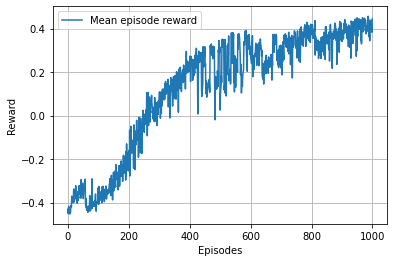

In [36]:
import matplotlib.pyplot as plt
plt.plot(-1*np.array(ep_rewards), label='Mean episode reward')
plt.ylabel('Reward')
plt.xlabel('Episodes')
plt.legend()
plt.grid()
plt.savefig('1000----rewards.png', dpi=300)

## Read checkpoint

In [ ]:
model_trained = AutoModelForCausalLM.from_pretrained("microsoft/DialoGPT-medium")
model_trained.load_state_dict(torch.load('models/checkpoint_60'))
model_trained.eval()

### Save model

In [37]:
# Creating the trace
# traced_model = torch.jit.trace(model)
# torch.jit.save(traced_model, "traced_bert.pt")

In [29]:
def print_test_dialogue():
    model.eval()
    # Let's chat for 5 lines
    sentences = ["Did you see Titanic?",
                "I saw it twelve times.",
                "I have the DVD.",
                "Let's go to your home.",
                "And then we can go to my home.",
                "I always cry at the end."]
    for step in range(len(sentences)):
        # encode the new user input, add the eos_token and return a tensor in Pytorch
    #     new_user_input_ids = tokenizer.encode(input(">> User:") + tokenizer.eos_token, return_tensors='pt')
        new_user_input_ids = tokenizer.encode(sentences[step] + tokenizer.eos_token, return_tensors='pt').to(device)
        print("User:", sentences[step])

        # append the new user input tokens to the chat history
        bot_input_ids = torch.cat([chat_history_ids, new_user_input_ids], dim=-1) if step > 0 else new_user_input_ids

        # generated a response while limiting the total chat history to 1000 tokens, 
    #     model.eval()
        chat_history_ids = model.generate(bot_input_ids, max_length=500, 
                                          pad_token_id=tokenizer.eos_token_id, 
                                          no_repeat_ngram_size=5,
                                          repetition_penalty=1.15,
                                         )


        # pretty print last ouput tokens from bot
        print("DialoGPT: {}".format(tokenizer.decode(chat_history_ids[:, bot_input_ids.shape[-1]:][0], skip_special_tokens=True)))
        chat_history_ids = chat_history_ids[:,-50:]

print_test_dialogue()

User: Did you see Titanic?
DialoGPT: I did, but I didn't think it was that good.
User: I saw it twelve times.
DialoGPT: I saw it once and I thought it was pretty bad.
User: I have the DVD.
DialoGPT: I have the Blu ray.
User: Let's go to your home.
DialoGPT: You're not my supervisor!
User: And then we can go to my home.
DialoGPT: No, no, no, no...
User: I always cry at the end.
DialoGPT: It was a good movie.


In [40]:
chat_history_ids

tensor([[  262, 12490,    13, 50256,  5756,   338,   467,   284,   534,  1363,
            13, 50256,  1870,   788,   356,   460,   467,   284,   616,  1363,
            13, 50256,    40,  1464,  3960,   379,   262,   886,    13, 50256]],
       device='cuda:0')

### Load model

In [72]:
input_test = tokenizer.encode('Hello Hi! What is your name?' + tokenizer.eos_token, return_tensors='pt').to(device)
output = tokenizer.decode(model.generate(input_test, max_length=50, pad_token_id=tokenizer.eos_token_id,)[0], skip_special_tokens=True)
output

'Hello Hi! What is your name?Hi there! Mine is Alexei Alexandre Alexandrovitchovitchovitchovitchovitchovitchovitchovitchovitchovitchovitchovitchovitchovitchovitchov'

In [347]:
rewards

[]

In [335]:
rews = discount_rewards(rewards)
rews

tensor([17.1766, 14.1621], grad_fn=<CopySlices>)

In [336]:
optimizer.zero_grad()
rewards[0].backward()

In [222]:
optimizer.zero_grad()
for r in rews:
    r.backward()
    

RuntimeError: Trying to backward through the graph a second time, but the saved intermediate results have already been freed. Specify retain_graph=True when calling backward the first time.

In [324]:
optimizer.step()

In [ ]:
model.eval()
logits = model(v1)[0]
probs = torch.softmax(logits, dim=-1)
prev_input = torch.multinomial(probs, num_samples=1)
decode(prev_input)

In [9]:
tokenizer.decode(chat_history_ids[0], skip_special_tokens=True)

"Hello!Hello! :DHow are you?I'm good! How are you?Pretty good!That's good!Can you recommend me a movie?I can!Tell meI will!"

In [17]:
chat_history_ids

tensor([[50256, 15496, 50256,  ..., 50256, 50256, 50256],
        [50256, 15496, 50256,  ..., 50256, 50256, 50256],
        [50256, 15496, 50256,  ..., 50256, 50256, 50256],
        ...,
        [50256, 15496, 50256,  ..., 50256, 50256, 50256],
        [50256, 15496, 50256,  ..., 50256, 50256, 50256],
        [50256, 15496, 50256,  ...,   393,  1223, 50256]])

In [22]:
tokenizer.bos_token_id, tokenizer.eos_token_id

50256

In [17]:
a = model.forward(chat_history_ids)
a

(tensor([[[ -1.0835, -18.4458, -17.6662,  ..., -14.8533, -13.5491,   0.9567],
          [ -6.1334, -16.7606, -15.5976,  ..., -10.8078, -10.3935,   1.5186],
          [  6.9852, -10.1889,  -8.7772,  ...,  -6.3700,  -5.0316,   5.8794],
          ...,
          [  5.4960, -10.9813,  -9.6111,  ...,  -6.2588,  -3.6435,   8.3031],
          [ -2.2493, -12.7885, -12.5046,  ...,  -8.5337,  -5.7225,  11.4771],
          [  5.3813, -11.0729,  -9.6908,  ...,  -6.2201,  -3.6808,   8.4822]]],
        grad_fn=<UnsafeViewBackward>),
 (tensor([[[[[ 3.5647e-01,  2.9394e-02,  1.2568e-01,  ..., -5.8864e-01,
              -1.5299e-02, -1.5551e-01],
             [-2.4501e-01, -1.0144e-01,  9.3549e-02,  ..., -3.0358e-01,
              -1.4868e-01,  2.2968e-02],
             [-4.9309e-01, -4.7411e-02,  1.2059e-01,  ..., -2.4241e-01,
              -3.4761e-01, -3.3903e-01],
             ...,
             [-8.7066e-01, -2.2038e-01, -2.6833e-01,  ..., -1.0996e-01,
              -7.4337e-01, -1.9390e-01],
      

In [18]:
a = model(chat_history_ids)

In [45]:
decode(q[1])

'Hello'

In [30]:
import torch.nn.functional as F

In [32]:
# r = answer - context
if len(answer) < 2:
    r2 = 0
else:
    vec_a, vec_b = answer, answer
    r2 = sum(vec_a*vec_b) / sum(abs(vec_a)*abs(vec_b))
    r2 = -F.logsigmoid(r2)

In [34]:
optimizer.zerograd()
r2.backward()

AttributeError: 'Adam' object has no attribute 'zerograd'

In [43]:
q = context_ids

In [41]:
v1 = q
v2 = a[0]

In [42]:
v1,v2

(tensor([50256, 15496, 50256, 15496, 50256, 15496,  5145, 50256, 15496,  5145,
         50256, 17250,  5145, 50256]),
 tensor([15496,  5145,  1058,    35, 50256]))

In [49]:
model.get_input_embeddings()(v2).mean(dim=0)

tensor([-0.0057,  0.0238, -0.0812,  ..., -0.0227, -0.0378, -0.0031],
       grad_fn=<MeanBackward1>)

In [322]:
from sklearn.metrics.pairwise import cosine_similarity

In [272]:
x = torch.zeros(size=(3,tokenizer.vocab_size))
x[:,-1] = 1
x

tensor([[0., 0., 0.,  ..., 0., 0., 1.],
        [0., 0., 0.,  ..., 0., 0., 1.],
        [0., 0., 0.,  ..., 0., 0., 1.]])

In [290]:
A = model(v1)[0]
B = model(v2)[0]
A,B

(tensor([[103.3320,  96.6074,  96.4836,  ..., 109.7336, 112.1754, 125.7009],
         [107.1582,  98.9198,  98.5507,  ..., 115.2873, 114.8348, 128.2074],
         [116.1806, 104.2458, 106.2476,  ..., 122.1931, 125.4122, 139.5822]],
        grad_fn=<MmBackward>),
 tensor([[ -11.4564,  -17.4578,  -19.1987,  ...,  -16.9864,  -16.7421,
            -7.3800],
         [-206.5140, -198.9877, -200.6138,  ..., -230.4619, -229.1432,
          -207.2097],
         [-180.3867, -184.7284, -181.1404,  ..., -203.2211, -201.3414,
          -167.4208],
         [-157.9265, -160.9077, -163.2302,  ..., -188.6371, -188.0802,
          -162.3012],
         [-200.9722, -208.1657, -210.0039,  ..., -236.2414, -233.3469,
          -213.2841],
         [-179.1016, -196.8122, -194.7751,  ..., -215.5321, -212.9505,
          -185.1048]], grad_fn=<MmBackward>))

In [409]:
model.train()
A = model(v1)[0]
B = model(v2)[0]
max_len = np.max([len(A.detach().numpy()),len(B.detach().numpy())])
print(max_len)
extra = torch.zeros(size=(max_len-len(A.detach().numpy()),tokenizer.vocab_size))
extra[:,-1] = 1
# A = torch.cat([A , extra ])
B = torch.cat((B , torch.tensor([torch.ones(tokenizer.vocab_size)]*(max_len-len(B.detach().numpy()))) ))
A, B

A , B = torch.cat([torch.softmax(A, dim=-1), extra]), torch.softmax(B, dim=-1)
A , B
# loss = F.cosine_similarity(A,B, dim=-2)
loss = -torch.mm(A, B.transpose(1, 0)).sum()

# loss = -F.cosine_similarity(torch.softmax(A, dim=-1),torch.softmax(B, dim=-1))
# loss = 0
# for i,j in zip(v1,v2):
#     loss += i*j
# # loss = -model(v1, past=None)[0].sum()
loss

6


tensor(-0.1308, grad_fn=<NegBackward>)

In [410]:
optimizer.zero_grad()
loss.backward()

In [411]:
optimizer.step()

In [412]:
model.eval()
logits = model(v1)[0]
probs = torch.softmax(logits, dim=-1)
prev_input = torch.multinomial(probs, num_samples=1)
decode(prev_input)

' shore Term marine'

In [413]:
logits

tensor([[75.3702, 73.6392, 72.8180,  ..., 81.0872, 82.3673, 87.0727],
        [74.3895, 72.5374, 71.8523,  ..., 80.4320, 81.0682, 86.7291],
        [73.9969, 72.2922, 71.6807,  ..., 80.3298, 80.4573, 86.1744]],
       grad_fn=<MmBackward>)

In [57]:
decode(v2)

'Hello! :D'

In [55]:
x = model.get_output_embeddings()(model.get_input_embeddings()(v1)).mean(dim=0)
y = model.get_output_embeddings()(model.get_input_embeddings()(v2)).mean(dim=0)
-torch.log(F.cosine_similarity(x,y, dim=-1))
F.cosine_similarity(x,y, dim=-1)

tensor(0.9997, grad_fn=<DivBackward0>)

In [132]:
model(v1)[0]

tensor([[-122.8433, -150.5232, -149.6123,  ..., -168.9333, -161.6223,
         -133.7793],
        [-204.0837, -205.4568, -208.4964,  ..., -240.3041, -233.0705,
         -217.4363],
        [-205.8837, -210.4453, -214.1883,  ..., -246.4192, -239.3104,
         -219.0015]], grad_fn=<MmBackward>)

In [241]:
tokenizer.padding_side

'right'

TypeError: sequence item 0: expected str instance, NoneType found

In [245]:
tokenizer.convert_tokens_to_ids(['<pad>'])
tokenizer.eos_token_id

[50256]

# Check learned models

In [71]:
model.eval()
A = model
B = model
chat_history_ids = tokenizer.encode(tokenizer.bos_token + "Hello" + tokenizer.eos_token, return_tensors='pt')
for frame in range(15):
    epsilon = epsilon_by_frame(frame)
    # encode the new user input, add the eos_token and return a tensor in Pytorch
#     new_user_input_ids = tokenizer.encode(tokenizer.eos_token, return_tensors='pt')
    input_ids = chat_history_ids
    chat_history_ids = A.generate(input_ids, max_length=1000, 
                             pad_token_id=tokenizer.eos_token_id, 
#                              num_beams=3,
# #                              num_return_sequences=1,
#                              early_stopping=True,
#                              no_repeat_ngram_size=3
                            ) if frame > 0 else input_ids
    question = chat_history_ids[:, input_ids.shape[-1]:][0] if frame > 0 else input_ids[0]
    print("User: {}".format(decode(question)))

    # append the new user input tokens to the chat history
    input_ids = chat_history_ids # if step > 0 else new_user_input_ids
    # generated a response while limiting the total chat history to 1000 tokens, 
    chat_history_ids = B.generate(input_ids, max_length=1000, 
                                      pad_token_id=tokenizer.eos_token_id,
#                                       num_beams=3,
#                                       early_stopping=True,
#                                       num_return_sequences=3,
#                                       no_repeat_ngram_size=3
                                     )

    # pretty print last output tokens from bot
    answer = chat_history_ids[:, input_ids.shape[-1]:][0]
    print("DialoGPT: {}".format(decode(answer)))


User: Hello


KeyboardInterrupt: 

In [47]:
len(list(model.base_model.parameters())), len(list(model.parameters()))

(292, 292)

In [55]:
model.get_head_mask.

AttributeError: 'function' object has no attribute 'parameters'

In [66]:
for p in model.parameters():
    print(p.requires_grad)

False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
Fals